In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, hamming_loss, jaccard_score)
from sklearn.multioutput import MultiOutputClassifier
import joblib
import time
import os
from IPython.display import display, Markdown, HTML
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def load_data(data_path):
    """Load and display initial dataset information"""
    print(f"1. Data Loading")
    print(f"Loading data from {data_path}")
    
    # Load the dataset
    data = pd.read_csv(data_path)
    
    print(f"Dataset loaded successfully with shape: {data.shape}")
    print("Sample data:")
    display(data.head())
    
    return data

In [3]:
def preprocess_data(data):
    """Preprocess data and perform exploratory analysis"""
    print("\n2. Data Preprocessing and Exploratory Analysis")
    
    # Separate features and target variables
    feature_cols = ['DO', 'pH', 'Alkalinity', 'Hardness', 'Nitrite', 'H2S', 'Salinity', 'Ammonia', 'Temperature']
    target_cols = ['WSS', 'AHPND', 'TSV', 'YHV']
    
    X = data[feature_cols]
    y = data[target_cols]
    
    # Display feature statistics
    print("Feature Statistics:")
    display(X.describe())
    
    # Visualize feature distributions
    print("Feature Distributions:")
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(feature_cols):
        sns.histplot(X[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Visualize class distribution
    print("\nClass Distribution:")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(target_cols):
        sns.countplot(x=y[col], ax=axes[i], palette='viridis')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        
        # Add count labels
        for p in axes[i].patches:
            axes[i].annotate(f'{int(p.get_height())}', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Check for missing values
    if data.isnull().sum().sum() == 0:
        print("\nNo missing values detected.")
    else:
        print("\nMissing values detected:")
        display(data.isnull().sum())
    
    # Visualize feature correlations
    print("\nFeature Correlations:")
    plt.figure(figsize=(12, 10))
    correlation = X.corr()
    mask = np.triu(correlation)
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Visualize disease co-occurrence
    print("\nDisease Co-occurrence:")
    plt.figure(figsize=(10, 8))
    disease_corr = y.corr()
    sns.heatmap(disease_corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Disease Co-occurrence Matrix')
    plt.tight_layout()
    plt.show()
    
    # Visualize feature scaling effect
    print("\nFeature Scaling Effect:")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Before scaling
    sns.boxplot(data=X, ax=axes[0])
    axes[0].set_title('Feature Distribution Before Scaling')
    axes[0].set_xlabel('Features')
    axes[0].set_ylabel('Value')
    axes[0].tick_params(axis='x', rotation=90)
    
    # After scaling
    sns.boxplot(data=X_scaled_df, ax=axes[1])
    axes[1].set_title('Feature Distribution After Scaling')
    axes[1].set_xlabel('Features')
    axes[1].set_ylabel('Standardized Value')
    axes[1].tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFeatures shape after preprocessing: {X.shape}")
    print(f"Labels shape after preprocessing: {y.shape}")
    
    return X, y, feature_cols, target_cols, scaler

In [4]:
def split_data(X, y, test_size=0.2, random_state=42):
    """Split data into train and test sets"""
    print("\n3. Train-Test Split")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Testing set size: {X_test.shape[0]} samples")
    
    return X_train, X_test, y_train, y_test

In [19]:
def tune_hyperparameters(X_train, y_train, random_state=42):
    """Tune SVM hyperparameters using Grid Search for all disease targets"""
    print(f"\n4. Hyperparameter Tuning for SVM")
    print(f"Tuning hyperparameters using all disease targets simultaneously...")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Define parameter grid
    param_grid = {
        'estimator__C': [0.1, 1, 10, 100],
        'estimator__gamma': ['scale', 'auto', 0.1, 0.01],
        'estimator__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
    }
    
    # Initialize base SVM model
    base_model = SVC(probability=True, random_state=random_state)
    
    # Create MultiOutputClassifier with SVM
    svm_model = MultiOutputClassifier(base_model)
    
    print("Starting hyperparameter search for SVM (this may take a while)...")
    start_time = time.time()
    
    # Perform Grid Search
    grid_search = GridSearchCV(
        svm_model, 
        param_grid, 
        scoring='accuracy', 
        cv=3, 
        n_jobs=-1, 
        verbose=1
    )
    
    # Use all disease targets
    grid_search.fit(X_train_scaled, y_train)
    
    end_time = time.time()
    
    print(f"Hyperparameter tuning completed in {end_time - start_time:.2f} seconds.")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    # Display results
    print("Hyperparameter Search Results:")
    results_df = pd.DataFrame(grid_search.best_params_.items(), columns=['Parameter', 'Value'])
    display(HTML("<b>Best SVM Hyperparameters:</b>"))
    display(results_df)
    
    # Visualize hyperparameter search results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Plot performance for different kernels
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='param_estimator__kernel', y='mean_test_score', data=results)
    plt.title('Performance by Kernel Type')
    plt.xlabel('Kernel')
    plt.ylabel('Cross-Validation Accuracy')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot performance by C and gamma for the best kernel
    best_kernel = grid_search.best_params_['estimator__kernel']
    kernel_results = results[results['param_estimator__kernel'] == best_kernel]
    
    plt.figure(figsize=(12, 8))
    pivot = kernel_results.pivot_table(
        values='mean_test_score', 
        index='param_estimator__C', 
        columns='param_estimator__gamma'
    )
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='viridis')
    plt.title(f'Performance by C and Gamma (Kernel: {best_kernel})')
    plt.tight_layout()
    plt.show()
    
    return grid_search.best_params_

In [8]:
def train_svm_models(X_train, X_test, y_train, y_test, best_params, target_cols, random_state=42):
    """Train SVM models with tuned hyperparameters"""
    print("\n5. Training SVM Models")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    models = {}
    results = {}
    confusion_matrices = {}
    
    for target in target_cols:
        print(f"\nTraining SVM for {target}...")
        start_time = time.time()
        
        # Create SVM model with best parameters
        svm = SVC(
            C=best_params['estimator__C'],
            gamma=best_params['estimator__gamma'],
            kernel=best_params['estimator__kernel'],
            probability=True,
            random_state=random_state
        )
        
        # Train model
        svm.fit(X_train_scaled, y_train[target])
        
        # Make predictions
        y_pred = svm.predict(X_test_scaled)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test[target], y_pred)
        precision = precision_score(y_test[target], y_pred)
        recall = recall_score(y_test[target], y_pred)
        f1 = f1_score(y_test[target], y_pred)
        
        end_time = time.time()
        training_time = end_time - start_time
        
        # Store results
        results[target] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time
        }
        
        # Store confusion matrix
        cm = confusion_matrix(y_test[target], y_pred)
        confusion_matrices[target] = cm
        
        # Store model
        models[target] = svm
        
        # Print results
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Training time: {training_time:.2f} seconds")
    
    # Visualize confusion matrices
    print("\nConfusion Matrices:")
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for i, target in enumerate(target_cols):
        cm = confusion_matrices[target]
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            ax=axes[i],
            cbar=False
        )
        axes[i].set_title(f'Confusion Matrix for {target}')
        axes[i].set_xlabel('Predicted Labels')
        axes[i].set_ylabel('True Labels')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate overall performance metrics
    all_y_true = np.hstack([y_test[col].values.reshape(-1, 1) for col in target_cols])
    all_y_pred = np.hstack([models[col].predict(X_test_scaled).reshape(-1, 1) for col in target_cols])
    
    overall_accuracy = accuracy_score(all_y_true.flatten(), all_y_pred.flatten())
    overall_hamming_loss = hamming_loss(all_y_true, all_y_pred)
    overall_jaccard = jaccard_score(all_y_true, all_y_pred, average='samples')
    
    print("\nOverall Model Performance:")
    print(f"Accuracy: {overall_accuracy:.4f}")
    print(f"Hamming Loss: {overall_hamming_loss:.4f}")
    print(f"Jaccard Score: {overall_jaccard:.4f}")
    
    # Feature importance analysis (for linear kernel only)
    if best_params['estimator__kernel'] == 'linear':
        print("\nFeature Importance Analysis:")
        
        feature_cols = X_train.columns
        importance_data = []
        
        for target in target_cols:
            if hasattr(models[target], 'coef_'):
                importance = np.abs(models[target].coef_[0])
                importance_data.append(pd.Series(importance, index=feature_cols, name=target))
        
        if importance_data:
            importance_df = pd.concat(importance_data, axis=1)
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(importance_df, annot=True, fmt='.3f', cmap='YlGnBu')
            plt.title('Feature Importance (Coefficient Magnitude)')
            plt.tight_layout()
            plt.show()
            
            # Plot top features for each disease
            plt.figure(figsize=(14, 10))
            
            for i, target in enumerate(target_cols):
                if target in importance_df.columns:
                    plt.subplot(2, 2, i+1)
                    importance_df[target].sort_values().plot(kind='barh')
                    plt.title(f'Feature Importance for {target}')
                    plt.tight_layout()
            
            plt.tight_layout()
            plt.show()
    else:
        print("\nFeature importance analysis not available for non-linear kernels.")
    return models, results, confusion_matrices, scaler

In [9]:
def save_models(models, scaler, feature_cols, target_cols, output_dir='model'):
    """Save models and artifacts to disk"""
    print("\n6. Saving Models and Artifacts")
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save models
    for target, model in models.items():
        model_path = os.path.join(output_dir, f'svm_model_{target}.pkl')
        joblib.dump(model, model_path)
        print(f"Saved model for {target} to {model_path}")
    
    # Save scaler
    scaler_path = os.path.join(output_dir, 'scaler.pkl')
    joblib.dump(scaler, scaler_path)
    print(f"Saved scaler to {scaler_path}")
    
    # Save metadata
    metadata = {
        'feature_columns': feature_cols,
        'target_columns': target_cols,
        'date_created': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    metadata_path = os.path.join(output_dir, 'metadata.pkl')
    joblib.dump(metadata, metadata_path)
    print(f"Saved metadata to {metadata_path}")
    
    # Create and save model summary
    summary = [
        "# SVM Model Summary",
        f"Date created: {metadata['date_created']}",
        f"Features: {', '.join(feature_cols)}",
        f"Targets: {', '.join(target_cols)}",
        f"Models: {', '.join([f'svm_model_{target}.pkl' for target in target_cols])}",
    ]
    
    summary_path = os.path.join(output_dir, 'model_summary.txt')
    with open(summary_path, 'w') as f:
        f.write('\n'.join(summary))
    
    print(f"Saved model summary to {summary_path}")

In [10]:
def cross_validate_models(X, y, best_params, target_cols, n_folds=5, random_state=42):
    """Perform cross-validation on SVM models"""
    print("\n7. Cross-Validation Evaluation")
    print(f"Performing {n_folds}-fold cross-validation...")
    
    # Define folds
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Initialize results storage
    cv_results = {target: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for target in target_cols}
    overall_results = {'accuracy': [], 'hamming_loss': []}
    
    # Perform cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        print(f"\nFold {fold}/{n_folds}")
        
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        all_y_true = []
        all_y_pred = []
        
        # Train and evaluate models for each target
        for target in target_cols:
            print(f"  Training for {target}...")
            
            # Create SVM model with best parameters
            svm = SVC(
                C=best_params['estimator__C'],
                gamma=best_params['estimator__gamma'],
                kernel=best_params['estimator__kernel'],
                probability=True,
                random_state=random_state
            )
            
            # Train model
            svm.fit(X_train_scaled, y_train[target])
            
            # Make predictions
            y_pred = svm.predict(X_test_scaled)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test[target], y_pred)
            precision = precision_score(y_test[target], y_pred)
            recall = recall_score(y_test[target], y_pred)
            f1 = f1_score(y_test[target], y_pred)
            
            # Store results
            cv_results[target]['accuracy'].append(accuracy)
            cv_results[target]['precision'].append(precision)
            cv_results[target]['recall'].append(recall)
            cv_results[target]['f1'].append(f1)
            
            print(f"    Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
            
            # Store for overall metrics
            all_y_true.append(y_test[target].values.reshape(-1, 1))
            all_y_pred.append(y_pred.reshape(-1, 1))
        
        # Calculate overall metrics
        all_y_true_np = np.hstack(all_y_true)
        all_y_pred_np = np.hstack(all_y_pred)
        
        overall_accuracy = accuracy_score(all_y_true_np.flatten(), all_y_pred_np.flatten())
        overall_hamming_loss = hamming_loss(all_y_true_np, all_y_pred_np)
        
        overall_results['accuracy'].append(overall_accuracy)
        overall_results['hamming_loss'].append(overall_hamming_loss)
        
        print(f"  Overall Accuracy: {overall_accuracy:.4f}, Hamming Loss: {overall_hamming_loss:.4f}")
    
    # Summarize cross-validation results
    print("\nCross-Validation Summary:")
    cv_summary = []
    
    for target in target_cols:
        target_results = {
            'Disease': target,
            'Accuracy': f"{np.mean(cv_results[target]['accuracy']):.4f} ± {np.std(cv_results[target]['accuracy']):.4f}",
            'Precision': f"{np.mean(cv_results[target]['precision']):.4f} ± {np.std(cv_results[target]['precision']):.4f}",
            'Recall': f"{np.mean(cv_results[target]['recall']):.4f} ± {np.std(cv_results[target]['recall']):.4f}",
            'F1 Score': f"{np.mean(cv_results[target]['f1']):.4f} ± {np.std(cv_results[target]['f1']):.4f}"
        }
        cv_summary.append(target_results)
    
    # Add overall results
    overall_result = {
        'Disease': 'Overall',
        'Accuracy': f"{np.mean(overall_results['accuracy']):.4f} ± {np.std(overall_results['accuracy']):.4f}",
        'Precision': 'N/A',
        'Recall': 'N/A',
        'F1 Score': f"{(np.mean(overall_results['accuracy']) - np.mean(overall_results['hamming_loss'])):.4f} ± {np.std(overall_results['accuracy']):.4f}"
    }
    cv_summary.append(overall_result)
    
    # Display results
    cv_summary_df = pd.DataFrame(cv_summary)
    display(cv_summary_df)
    
    # Visualize cross-validation performance
    print("Cross-Validation Performance Visualization:")
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    disease_means = {}
    disease_std = {}
    
    for target in target_cols:
        disease_means[target] = [
            np.mean(cv_results[target]['accuracy']),
            np.mean(cv_results[target]['precision']),
            np.mean(cv_results[target]['recall']),
            np.mean(cv_results[target]['f1'])
        ]
        
        disease_std[target] = [
            np.std(cv_results[target]['accuracy']),
            np.std(cv_results[target]['precision']),
            np.std(cv_results[target]['recall']),
            np.std(cv_results[target]['f1'])
        ]
    
    # Create performance plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    index = np.arange(len(metrics))
    
    for i, target in enumerate(target_cols):
        position = index + i * bar_width
        bars = ax.bar(position, disease_means[target], bar_width, 
                      label=target, alpha=0.8, capsize=5)
        
        # Add error bars
        ax.errorbar(position, disease_means[target], yerr=disease_std[target], 
                    fmt='none', ecolor='black', capsize=5)
    
    ax.set_xlabel('Metric')
    ax.set_ylabel('Score')
    ax.set_title('Cross-Validation Performance by Disease')
    ax.set_xticks(index + bar_width * (len(target_cols) - 1) / 2)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Set y-axis to start at 0.8 for better visualization of differences
    ax.set_ylim(0.8, 1.02)
    
    plt.tight_layout()
    plt.show()
    
    return cv_summary_df

In [24]:
def predict_new_cases(models, scaler, feature_cols, target_cols, new_data,best_params, visualize=True):
    """Make predictions on new data"""
    print("\n8. Prediction on New Data")
    
    # Ensure columns match
    new_data = new_data[feature_cols].copy()
    
    # Display input data
    print("Input Data:")
    display(new_data)
    
    # Scale features
    X_new = scaler.transform(new_data)
    
    # Make predictions for each model
    predictions = []
    probabilities = {}
    
    for target in target_cols:
        # Predict class
        pred = models[target].predict(X_new)
        predictions.append(pred)
        
        # Predict probabilities
        proba = models[target].predict_proba(X_new)
        probabilities[target] = proba[:, 1]  # Probability of positive class
    
    # Convert predictions to array and then DataFrame
    predictions = np.array(predictions).T
    
    # Create probability DataFrame
    proba_data = pd.DataFrame(
        {target: probabilities[target] for target in target_cols},
        index=[f"Sample {i+1}" for i in range(X_new.shape[0])]
    )
    
    # Display probability predictions
    print("\nPrediction Probabilities:")
    plt.figure(figsize=(12, max(4, len(new_data) * 0.5)))
    
    # Use a custom heatmap for probabilities
    sns.heatmap(proba_data, cmap='YlOrRd', annot=True, fmt='.3f', cbar=True)
    plt.title('Disease Prediction Probabilities')
    plt.tight_layout()
    plt.show()
    
    # Display binary predictions
    print("\nBinary Predictions:")
    binary_data = pd.DataFrame(
        predictions, 
        columns=target_cols, 
        index=[f"Sample {i+1}" for i in range(X_new.shape[0])]
    )
    
    plt.figure(figsize=(12, max(4, len(new_data) * 0.5)))
    
    # Use a custom heatmap for binary predictions
    # Important: Use the right format specifier based on data type
    fmt = 'd' if np.issubdtype(binary_data.dtypes[0], np.integer) else '.2f'
    
    sns.heatmap(binary_data, 
                cmap=LinearSegmentedColormap.from_list("custom", ["#f7fbff", "#e74c3c"]), 
                annot=True, 
                fmt=fmt, 
                cbar=False)
    plt.title('Disease Binary Predictions (0: Negative, 1: Positive)')
    plt.tight_layout()
    plt.show()
    
    # Summarize potential risk factors based on predictions
    print("\nRisk Analysis:")
    
    for i in range(len(new_data)):
        sample_name = f"Sample {i+1}"
        predicted_diseases = [target for j, target in enumerate(target_cols) if predictions[i, j] == 1]
        
        if predicted_diseases:
            print(f"\n{sample_name} is predicted to have: {', '.join(predicted_diseases)}")
            
            # Find top contributing features for each predicted disease
            if best_params['estimator__kernel'] == 'linear':
                for disease in predicted_diseases:
                    coeffs = np.abs(models[disease].coef_[0])
                    feature_importance = pd.Series(coeffs, index=feature_cols)
                    top_features = feature_importance.nlargest(3)
                    
                    print(f"  Top risk factors for {disease}:")
                    for feature, importance in top_features.items():
                        value = new_data.iloc[i][feature]
                        print(f"    - {feature}: {value:.2f} (importance: {importance:.3f})")
            else:
                print("  (Detailed risk factor analysis not available for non-linear kernels)")
        else:
            print(f"\n{sample_name} is predicted to be healthy.")
    
    return {"probabilities": proba_data, "predictions": binary_data}

In [25]:
def run_pipeline(data_path, test_size=0.2, random_state=42):
    """Run the complete SVM pipeline"""
    print("Complete SVM Pipeline Execution")
    
    # Load data
    data = load_data(data_path)
    
    # Preprocess data
    X, y, feature_cols, target_cols, _ = preprocess_data(data)
    
    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y, test_size, random_state)
    
    # Tune hyperparameters using all target diseases
    best_params = tune_hyperparameters(X_train, y_train, random_state)
    
    # Train models
    models, results, confusion_matrices, scaler = train_svm_models(
        X_train, X_test, y_train, y_test, best_params, target_cols, random_state
    )
    
    # Save models
    save_models(models, scaler, feature_cols, target_cols)
    
    # Cross-validate models
    cv_summary = cross_validate_models(X, y, best_params, target_cols)
    
    # Make predictions on new data (using first few test samples as an example)
    sample_data = pd.DataFrame(X_test[:3].values, columns=feature_cols)
    
    # Make predictions
    predictions = predict_new_cases(models, scaler, feature_cols, target_cols, sample_data,best_params)
    
    # Create final summary
    display(Markdown("## Final Pipeline Summary"))
    print("SVM pipeline completed successfully!")
    print(f"Models trained for diseases: {', '.join(target_cols)}")
    print(f"Overall accuracy: {results['WSS']['accuracy']:.4f}")
    print("Models and artifacts saved to the 'model' directory")
    
    return {
        "models": models,
        "results": results,
        "scaler": scaler,
        "feature_cols": feature_cols,
        "target_cols": target_cols,
        "best_params": best_params
    }

Complete SVM Pipeline Execution
1. Data Loading
Loading data from C:\Users\naren\Desktop\4thyear models\Untitled Folder\dataset.csv
Dataset loaded successfully with shape: (6517, 13)
Sample data:


,DO,pH,Alkalinity,Hardness,Nitrite,H2S,Salinity,Ammonia,Temperature,WSS,AHPND,TSV,YHV
0,0.21,4.75,218.36,300.13,4.36,0.07,24.44,5.90,35.18,1,1,1,1
1,11.43,3.09,273.94,8.43,2.18,0.02,10.08,0.73,36.45,0,0,0,1
2,12.43,9.65,220.81,11.73,4.90,0.07,11.29,4.88,33.51,0,1,0,1
3,10.96,4.82,266.57,6.63,3.57,0.03,23.82,0.99,30.07,0,0,0,0
4,1.36,10.24,252.11,339.89,4.66,0.06,13.43,3.81,30.72,1,1,1,1



2. Data Preprocessing and Exploratory Analysis
Feature Statistics:


,DO,pH,Alkalinity,Hardness,Nitrite,H2S,Salinity,Ammonia,Temperature
count,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000,6517.000000
mean,5.525372,7.883738,99.744519,155.277540,0.556581,0.079333,18.794860,2.036512,32.291070
std,1.697620,1.414228,60.003889,89.406059,0.748328,0.112525,4.440123,1.837780,2.629629
min,0.030000,0.000000,20.000000,0.000000,0.000000,0.000000,10.010000,0.000000,28.000000
25%,4.310000,6.870000,48.240000,90.010000,0.020000,0.010000,14.980000,0.520000,30.010000
50%,5.430000,8.000000,94.880000,142.400000,0.350000,0.020000,20.130000,1.130000,32.210000
75%,6.660000,9.000000,121.000000,212.370000,0.650000,0.100000,22.650000,3.570000,34.560000
max,14.970000,14.850000,480.000000,816.000000,4.990000,0.490000,25.000000,6.000000,37.000000


Feature Distributions:


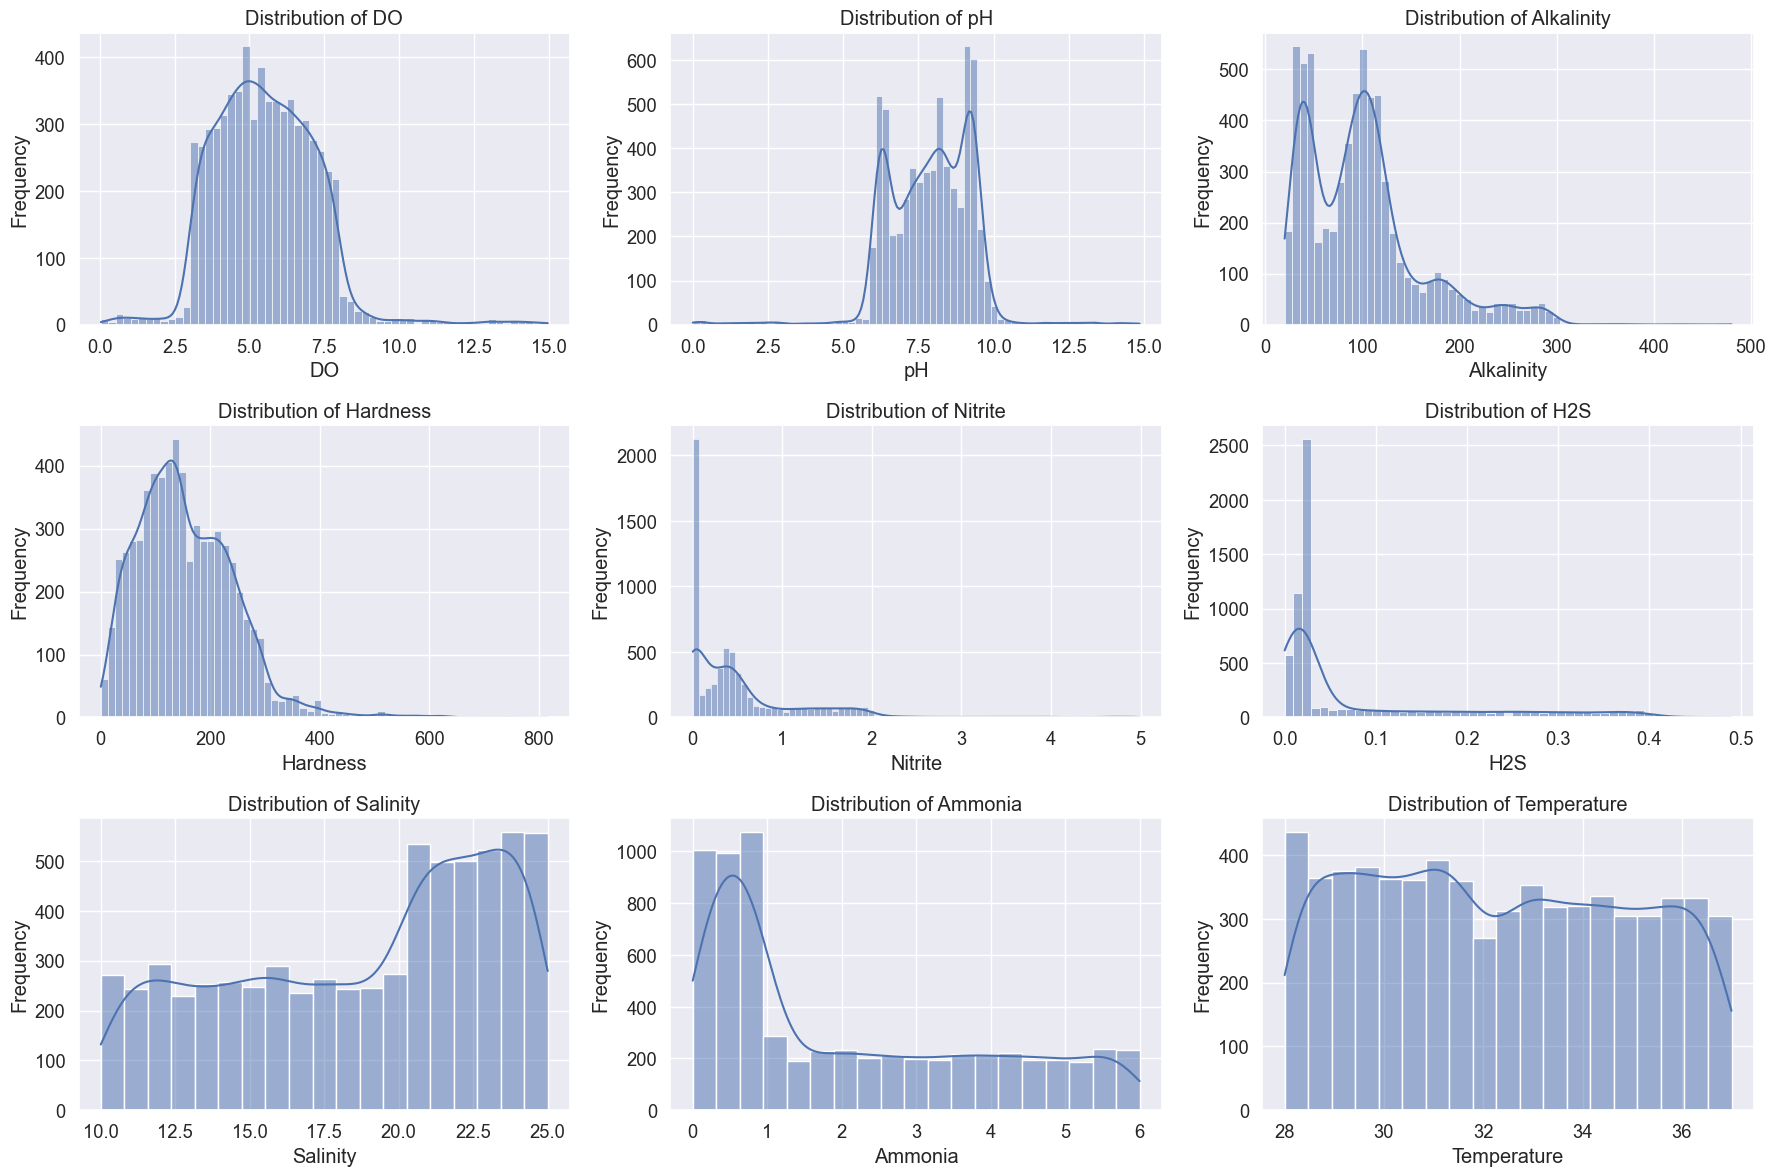


Class Distribution:


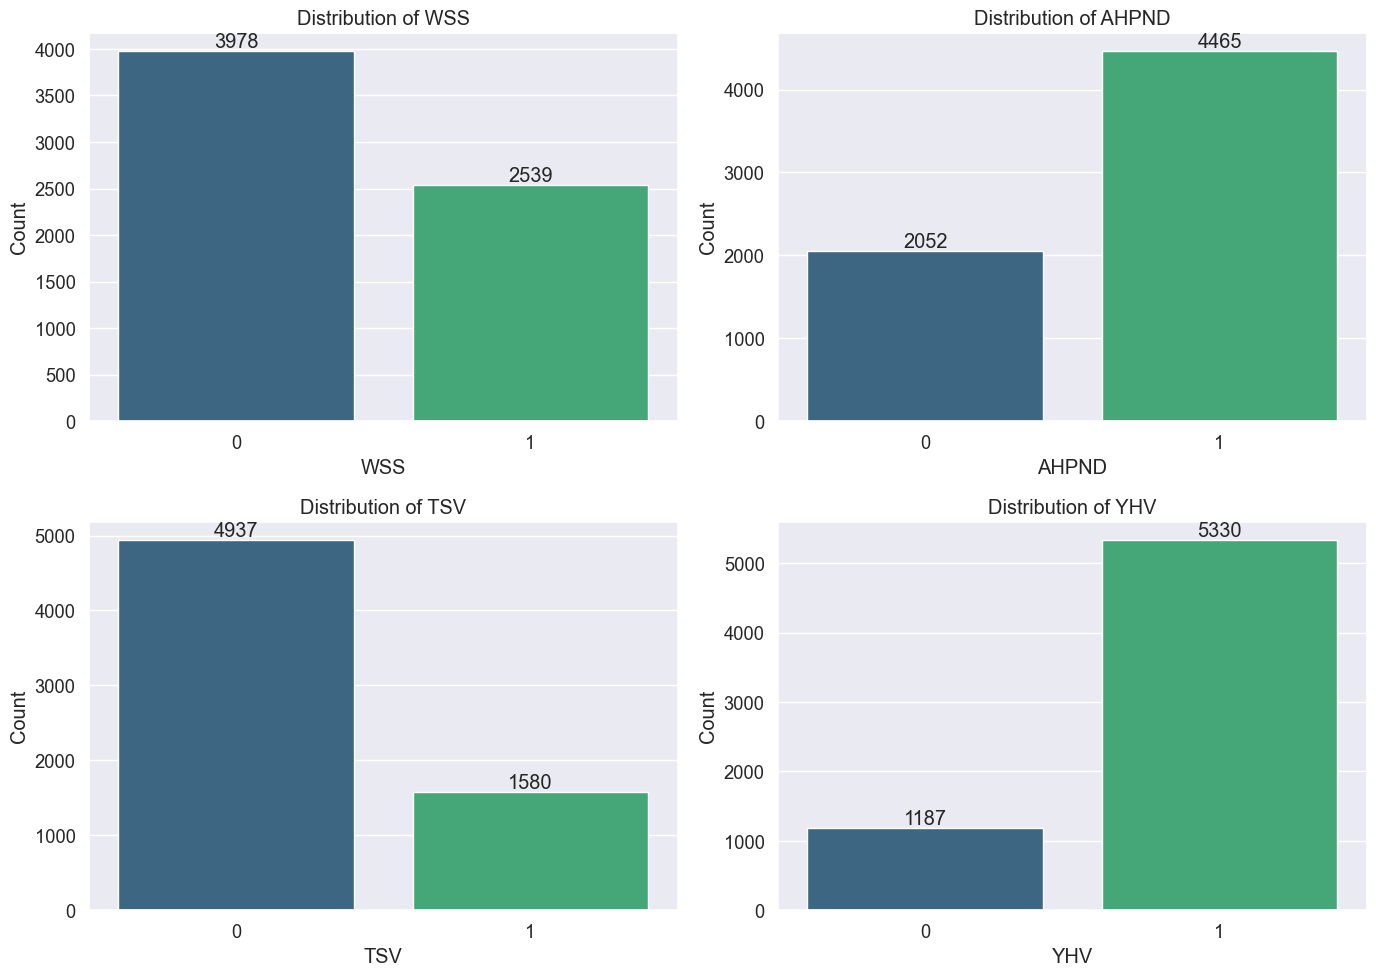


No missing values detected.

Feature Correlations:


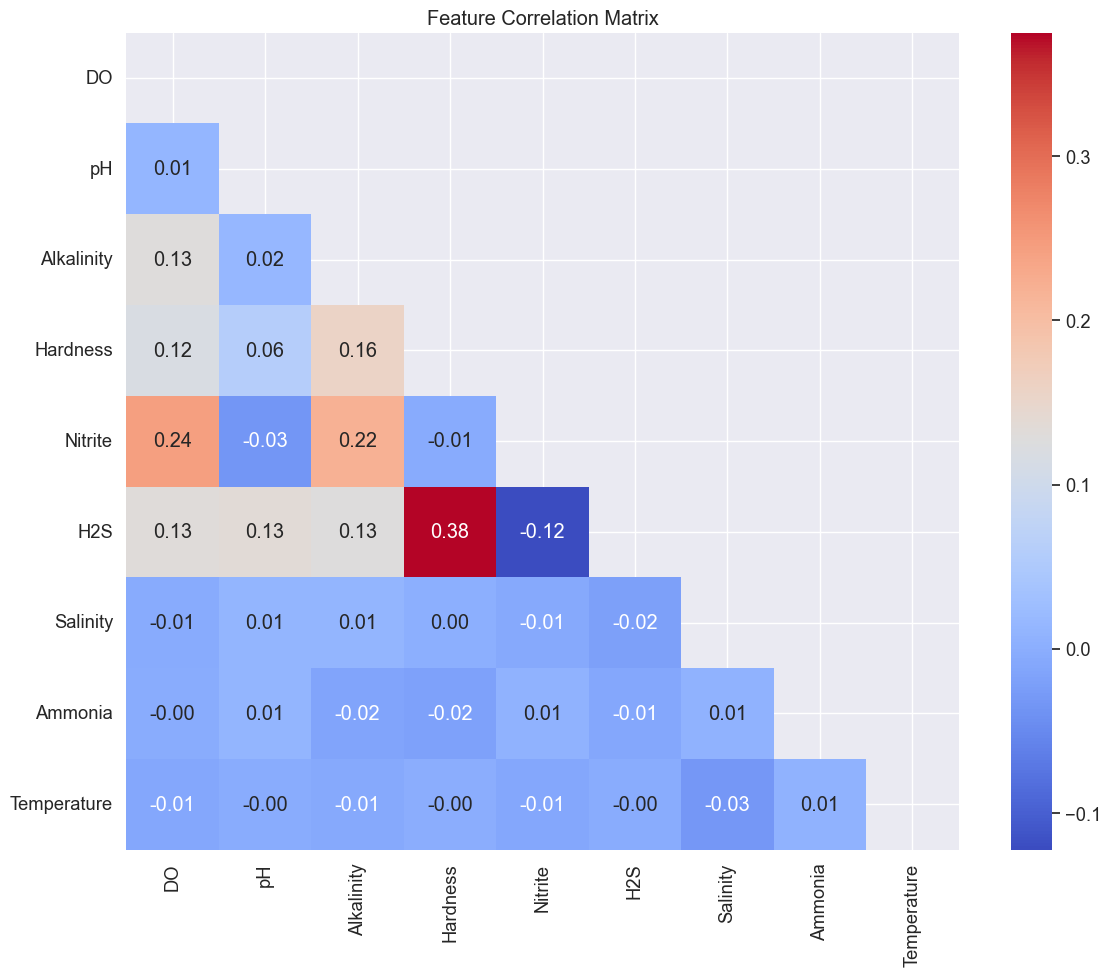


Disease Co-occurrence:


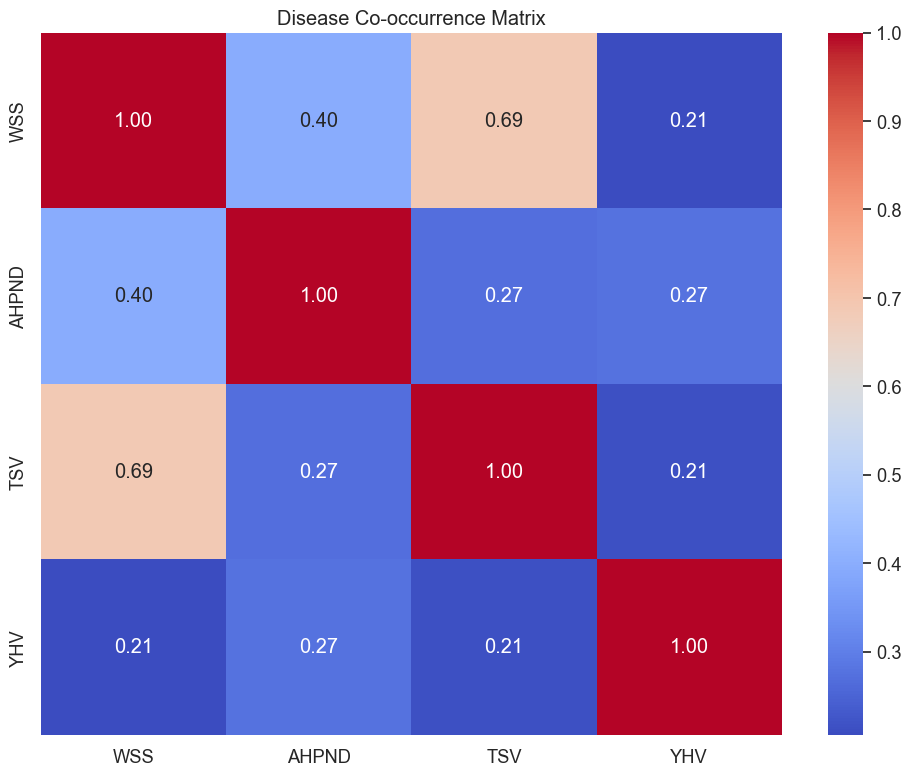


Feature Scaling Effect:


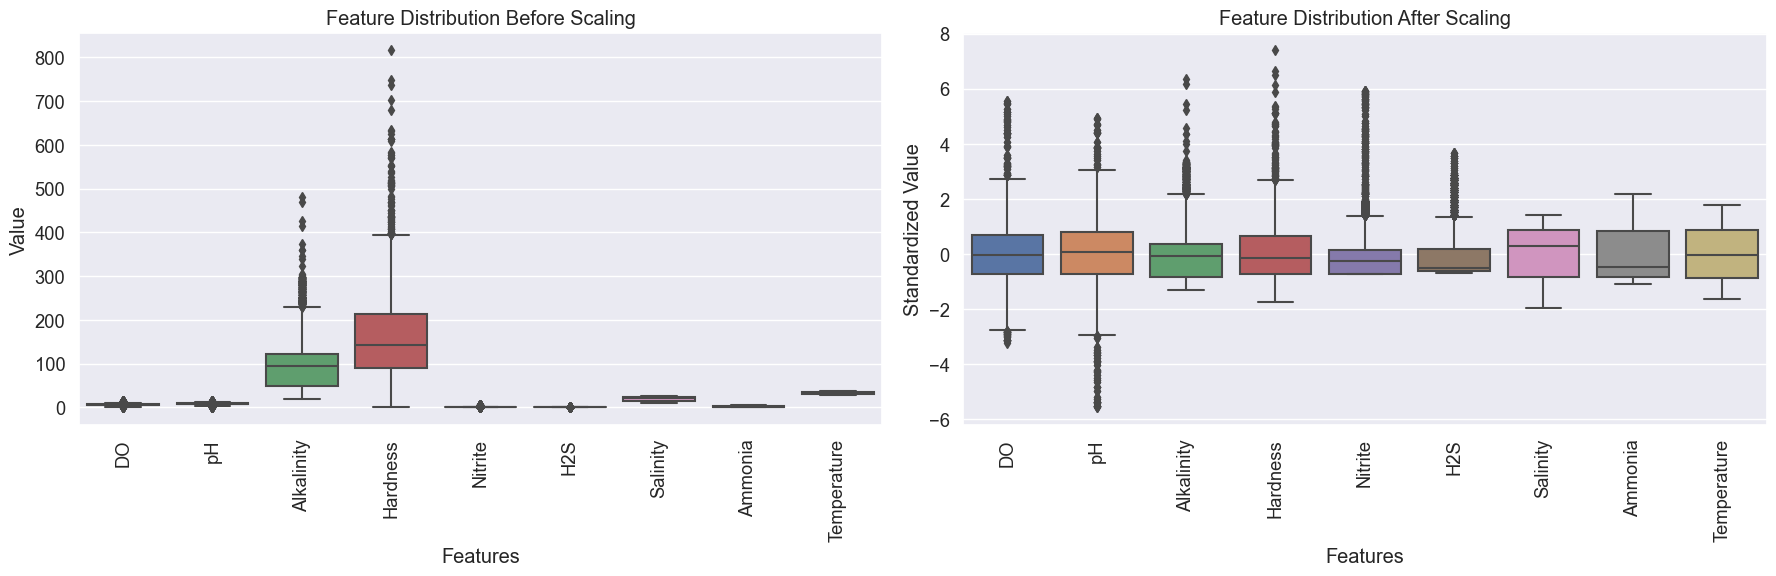


Features shape after preprocessing: (6517, 9)
Labels shape after preprocessing: (6517, 4)

3. Train-Test Split
Training set size: 5213 samples
Testing set size: 1304 samples

4. Hyperparameter Tuning for SVM
Tuning hyperparameters using all disease targets simultaneously...
Starting hyperparameter search for SVM (this may take a while)...
Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [ ]:
if __name__ == "__main__":
    # Define path to your dataset
    data_file = r"C:\Users\naren\Desktop\4thyear models\Untitled Folder\dataset.csv"  # Replace with your actual path
    
    # Run the complete pipeline
    pipeline_results = run_pipeline(data_file)
    
    

In [18]:
def load_saved_models(model_dir='model'):
        """Load saved models and artifacts from disk"""
        print("Loading saved models and artifacts...")
        
        # Load metadata
        metadata_path = os.path.join(model_dir, 'metadata.pkl')
        metadata = joblib.load(metadata_path)
        
        feature_cols = metadata['feature_columns']
        target_cols = metadata['target_columns']
        
        print(f"Model created on: {metadata['date_created']}")
        print(f"Features: {', '.join(feature_cols)}")
        print(f"Targets: {', '.join(target_cols)}")
        
        # Load scaler
        scaler_path = os.path.join(model_dir, 'scaler.pkl')
        scaler = joblib.load(scaler_path)
        
        # Load models
        models = {}
        for target in target_cols:
            model_path = os.path.join(model_dir, f'svm_model_{target}.pkl')
            models[target] = joblib.load(model_path)
            print(f"Loaded model for {target}")
        
        return models, scaler, feature_cols, target_cols
    
def create_prediction_app(models, scaler, feature_cols, target_cols):
        """Create a simple function to predict disease risk from input values"""
        
def predict_disease_risk(input_data):
            """
            Predict disease risk from input parameters
            
            Parameters:
            input_data (dict or DataFrame): Input water quality parameters
            
            Returns:
            dict: Prediction results including probabilities and classifications
            """
            # Convert input to DataFrame if it's a dictionary
            if isinstance(input_data, dict):
                data = pd.DataFrame([input_data])
            else:
                data = input_data.copy()
            
            # Ensure all required features are present
            for col in feature_cols:
                if col not in data.columns:
                    raise ValueError(f"Missing required feature: {col}")
            
            # Select only the required features
            data = data[feature_cols]
            
            # Scale the features
            X_scaled = scaler.transform(data)
            
            # Make predictions
            results = {
                'probabilities': {},
                'classifications': {}
            }
            
            for target in target_cols:
                # Get probability predictions
                proba = models[target].predict_proba(X_scaled)[:, 1]
                results['probabilities'][target] = proba
                
                # Get binary predictions
                pred = models[target].predict(X_scaled)
                results['classifications'][target] = pred
            
            # Convert to DataFrames for easier interpretation
            proba_df = pd.DataFrame(results['probabilities'])
            class_df = pd.DataFrame(results['classifications'])
            
            return {
                'probabilities_df': proba_df,
                'classifications_df': class_df,
                'probabilities': results['probabilities'],
                'classifications': results['classifications']
            }
        
        return predict_disease_risk
    
def deploy_web_interface():
        """Example code for deploying a web interface using Flask"""
        print("\nExample Flask Application for Model Deployment")
        
        # Import required packages
        flask_code = """
        from flask import Flask, request, jsonify, render_template
        import numpy as np
        import pandas as pd
        import joblib
        import os

        app = Flask(__name__)

        # Load the models
        model_dir = 'model'
        metadata = joblib.load(os.path.join(model_dir, 'metadata.pkl'))
        feature_cols = metadata['feature_columns']
        target_cols = metadata['target_columns']
        scaler = joblib.load(os.path.join(model_dir, 'scaler.pkl'))

        # Load models
        models = {}
        for target in target_cols:
            model_path = os.path.join(model_dir, f'svm_model_{target}.pkl')
            models[target] = joblib.load(model_path)

        @app.route('/')
        def home():
            return render_template('index.html', features=feature_cols, diseases=target_cols)

        @app.route('/predict', methods=['POST'])
        def predict():
            try:
                # Get input data from JSON
                data = request.json
                
                # Create DataFrame
                input_data = pd.DataFrame([data])
                
                # Select features
                features = input_data[feature_cols]
                
                # Scale features
                X_scaled = scaler.transform(features)
                
                # Make predictions
                results = {
                    'probabilities': {},
                    'predictions': {}
                }
                
                for target in target_cols:
                    # Get probability
                    proba = models[target].predict_proba(X_scaled)[0, 1]
                    results['probabilities'][target] = float(proba)
                    
                    # Get classification
                    pred = int(models[target].predict(X_scaled)[0])
                    results['predictions'][target] = pred
                
                return jsonify({
                    'success': True,
                    'results': results
                })
                
            except Exception as e:
                return jsonify({
                    'success': False,
                    'error': str(e)
                })

        if __name__ == '__main__':
            app.run(debug=True)
        """
        
        print(flask_code)
        
        # Example HTML template
        html_template = """
        <!DOCTYPE html>
        <html>
        <head>
            <title>Shrimp Disease Prediction</title>
            <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css">
            <style>
                body { padding: 20px; }
                .prediction-card { margin-top: 20px; }
                .high-risk { background-color: #f8d7da; }
                .medium-risk { background-color: #fff3cd; }
                .low-risk { background-color: #d4edda; }
            </style>
        </head>
        <body>
            <div class="container">
                <h1 class="mb-4">Shrimp Disease Prediction System</h1>
                
                <div class="card">
                    <div class="card-header">
                        <h4>Water Quality Parameters</h4>
                    </div>
                    <div class="card-body">
                        <form id="predictionForm">
                            <div class="row">
                                {% for feature in features %}
                                <div class="col-md-4 mb-3">
                                    <label for="{{ feature }}">{{ feature }}</label>
                                    <input type="number" step="0.01" class="form-control" id="{{ feature }}" name="{{ feature }}" required>
                                </div>
                                {% endfor %}
                            </div>
                            
                            <button type="submit" class="btn btn-primary">Predict Disease Risk</button>
                        </form>
                    </div>
                </div>
                
                <div id="results" style="display: none;">
                    <h3 class="mt-4">Prediction Results</h3>
                    
                    <div class="row">
                        {% for disease in diseases %}
                        <div class="col-md-6">
                            <div class="card prediction-card" id="{{ disease }}_card">
                                <div class="card-header">
                                    <h5>{{ disease }}</h5>
                                </div>
                                <div class="card-body">
                                    <p><strong>Risk Probability:</strong> <span id="{{ disease }}_prob"></span>%</p>
                                    <p><strong>Status:</strong> <span id="{{ disease }}_status"></span></p>
                                </div>
                            </div>
                        </div>
                        {% endfor %}
                    </div>
                    
                    <div class="card mt-4">
                        <div class="card-header">
                            <h5>Recommendations</h5>
                        </div>
                        <div class="card-body" id="recommendations">
                            <!-- Recommendations will be inserted here -->
                        </div>
                    </div>
                </div>
            </div>
            
            <script src="https://code.jquery.com/jquery-3.5.1.min.js"></script>
            <script>
                $(document).ready(function() {
                    $('#predictionForm').submit(function(e) {
                        e.preventDefault();
                        
                        // Collect form data
                        const formData = {};
                        $(this).serializeArray().forEach(function(item) {
                            formData[item.name] = parseFloat(item.value);
                        });
                        
                        // Send prediction request
                        $.ajax({
                            url: '/predict',
                            type: 'POST',
                            contentType: 'application/json',
                            data: JSON.stringify(formData),
                            success: function(response) {
                                if (response.success) {
                                    // Show results
                                    $('#results').show();
                                    
                                    // Update disease cards
                                    const diseases = {{ diseases|tojson }};
                                    let highRiskDiseases = [];
                                    
                                    diseases.forEach(function(disease) {
                                        const prob = (response.results.probabilities[disease] * 100).toFixed(2);
                                        const prediction = response.results.predictions[disease];
                                        
                                        $(`#${disease}_prob`).text(prob);
                                        $(`#${disease}_status`).text(prediction === 1 ? 'Positive' : 'Negative');
                                        
                                        // Set card color based on risk
                                        const card = $(`#${disease}_card`);
                                        card.removeClass('high-risk medium-risk low-risk');
                                        
                                        if (prob >= 75) {
                                            card.addClass('high-risk');
                                            if (prediction === 1) {
                                                highRiskDiseases.push(disease);
                                            }
                                        } else if (prob >= 40) {
                                            card.addClass('medium-risk');
                                        } else {
                                            card.addClass('low-risk');
                                        }
                                    });
                                    
                                    // Generate recommendations
                                    let recommendations = '';
                                    
                                    if (highRiskDiseases.length > 0) {
                                        recommendations += `<p><strong>High Risk Detected:</strong> ${highRiskDiseases.join(', ')}</p>`;
                                        recommendations += '<ul>';
                                        recommendations += '<li>Immediate action recommended</li>';
                                        recommendations += '<li>Consider water quality management interventions</li>';
                                        recommendations += '<li>Monitor shrimp health closely</li>';
                                        recommendations += '</ul>';
                                    } else if (Object.values(response.results.predictions).includes(1)) {
                                        recommendations += '<p><strong>Moderate Risk Detected</strong></p>';
                                        recommendations += '<ul>';
                                        recommendations += '<li>Regular monitoring recommended</li>';
                                        recommendations += '<li>Review water quality parameters</li>';
                                        recommendations += '</ul>';
                                    } else {
                                        recommendations += '<p><strong>Low Risk Profile</strong></p>';
                                        recommendations += '<ul>';
                                        recommendations += '<li>Continue regular monitoring</li>';
                                        recommendations += '<li>Maintain current water quality management practices</li>';
                                        recommendations += '</ul>';
                                    }
                                    
                                    $('#recommendations').html(recommendations);
                                } else {
                                    alert('Error: ' + response.error);
                                }
                            },
                            error: function() {
                                alert('An error occurred during prediction.');
                            }
                        });
                    });
                });
            </script>
        </body>
        </html>
        """
        
        print("\nHTML Template (Save as templates/index.html):")
        print(html_template)
        
        print("\nTo deploy the web interface:")
        print("1. Create a 'templates' folder in your project directory")
        print("2. Save the HTML template as 'templates/index.html'")
        print("3. Save the Flask code as 'app.py'")
        print("4. Install Flask: pip install flask")
        print("5. Run the application: python app.py")
        print("6. Open a web browser and navigate to http://127.0.0.1:5000")

def integrate_with_iot_sensors():
        """Example of integrating the model with IoT sensors for real-time monitoring"""
        print("\n10. IoT Integration Example")
        
        # Import required packages
        iot_code = """
        import time
        import random
        import pandas as pd
        import numpy as np
        import joblib
        import os
        import json
        import paho.mqtt.client as mqtt
        from datetime import datetime

        # Load models
        model_dir = 'model'
        metadata = joblib.load(os.path.join(model_dir, 'metadata.pkl'))
        feature_cols = metadata['feature_columns']
        target_cols = metadata['target_columns']
        scaler = joblib.load(os.path.join(model_dir, 'scaler.pkl'))

        # Load models
        models = {}
        for target in target_cols:
            model_path = os.path.join(model_dir, f'svm_model_{target}.pkl')
            models[target] = joblib.load(model_path)

        # MQTT configuration
        mqtt_broker = "localhost"  # Replace with actual broker address if needed
        mqtt_port = 1883
        mqtt_topic_data = "shrimp/sensors/data"
        mqtt_topic_predictions = "shrimp/predictions"

        # Connect to MQTT broker
        client = mqtt.Client()
        
        try:
            client.connect(mqtt_broker, mqtt_port, 60)
            client.loop_start()
            print(f"Connected to MQTT broker at {mqtt_broker}:{mqtt_port}")
        except Exception as e:
            print(f"Failed to connect to MQTT broker: {e}")
            print("Continuing with local simulation...")

        def predict_diseases(sensor_data):
            """Make predictions based on sensor data"""
            # Create DataFrame from sensor data
            data = pd.DataFrame([sensor_data])
            
            # Ensure we have all required features
            for feature in feature_cols:
                if feature not in data.columns:
                    data[feature] = 0  # Default value for missing features
            
            # Select only required features in correct order
            data = data[feature_cols]
            
            # Scale features
            X_scaled = scaler.transform(data)
            
            # Make predictions
            results = {
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'sensor_data': sensor_data,
                'predictions': {}
            }
            
            # Make predictions for each disease
            for target in target_cols:
                probability = float(models[target].predict_proba(X_scaled)[0, 1])
                prediction = int(models[target].predict(X_scaled)[0])
                
                results['predictions'][target] = {
                    'probability': probability,
                    'status': prediction
                }
            
            return results

        def simulate_sensor_readings():
            """Simulate IoT sensor readings for water quality parameters"""
            # Baseline values
            baseline = {
                'DO': 7.0,        # Dissolved Oxygen (mg/L)
                'pH': 7.5,        # pH
                'Alkalinity': 150, # Alkalinity (mg/L)
                'Hardness': 300,   # Hardness (mg/L)
                'Nitrite': 0.05,   # Nitrite (mg/L)
                'H2S': 0.002,      # Hydrogen Sulfide (mg/L)
                'Salinity': 15,    # Salinity (ppt)
                'Ammonia': 0.1,    # Ammonia (mg/L)
                'Temperature': 28   # Temperature (°C)
            }
            
            # Fluctuation ranges
            fluctuation = {
                'DO': 1.0,
                'pH': 0.5,
                'Alkalinity': 20,
                'Hardness': 50,
                'Nitrite': 0.02,
                'H2S': 0.001,
                'Salinity': 2,
                'Ammonia': 0.05,
                'Temperature': 1.5
            }
            
            while True:
                # Generate random readings with realistic fluctuations
                reading = {}
                
                for feature, value in baseline.items():
                    # Add random fluctuation
                    fluctuation_value = random.uniform(-fluctuation[feature], fluctuation[feature])
                    reading[feature] = round(value + fluctuation_value, 3)
                
                # Add timestamp
                reading['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                
                # Make predictions
                prediction_results = predict_diseases(reading)
                
                # Print results
                print(f"\\nTime: {reading['timestamp']}")
                print("Sensor Readings:")
                for feature, value in reading.items():
                    if feature != 'timestamp':
                        print(f"  {feature}: {value}")
                
                print("\\nDisease Predictions:")
                for disease, result in prediction_results['predictions'].items():
                    risk_level = "HIGH" if result['probability'] > 0.7 else ("MEDIUM" if result['probability'] > 0.3 else "LOW")
                    status = "POSITIVE" if result['status'] == 1 else "NEGATIVE"
                    print(f"  {disease}: {result['probability']:.4f} ({risk_level}) - Status: {status}")
                
                # Publish to MQTT topics
                try:
                    # Publish sensor data
                    client.publish(mqtt_topic_data, json.dumps(reading))
                    
                    # Publish predictions
                    client.publish(mqtt_topic_predictions, json.dumps(prediction_results))
                except Exception as e:
                    print(f"Failed to publish to MQTT: {e}")
                
                # Wait before next reading
                time.sleep(10)  # Simulate readings every 10 seconds

        # Start simulation
        if __name__ == "__main__":
            print("Starting IoT sensor simulation...")
            print("Press Ctrl+C to stop")
            
            try:
                simulate_sensor_readings()
            except KeyboardInterrupt:
                print("Simulation stopped")
                client.loop_stop()
                client.disconnect()
        """
        
        print(iot_code)
        
        print("\nTo run the IoT simulation:")
        print("1. Save the code as 'iot_integration.py'")
        print("2. Install required packages: pip install paho-mqtt")
        print("3. Optionally install an MQTT broker like Mosquitto")
        print("4. Run the simulation: python iot_integration.py")
    
def create_batch_processing_script():
        """Example batch processing script for multiple ponds/farms"""
        print("\n11. Batch Processing Example")
        
        batch_code = """
        import pandas as pd
        import numpy as np
        import joblib
        import os
        import glob
        import time
        from datetime import datetime

        def batch_process_files(input_dir, output_dir, model_dir='model'):
            """Process multiple CSV files with water quality data"""
            print(f"Starting batch processing of files in {input_dir}")
            print(f"Results will be saved to {output_dir}")
            
            # Create output directory if it doesn't exist
            os.makedirs(output_dir, exist_ok=True)
            
            # Load models and metadata
            metadata = joblib.load(os.path.join(model_dir, 'metadata.pkl'))
            feature_cols = metadata['feature_columns']
            target_cols = metadata['target_columns']
            scaler = joblib.load(os.path.join(model_dir, 'scaler.pkl'))
            
            # Load models
            models = {}
            for target in target_cols:
                model_path = os.path.join(model_dir, f'svm_model_{target}.pkl')
                models[target] = joblib.load(model_path)
            
            # Find all CSV files in the input directory
            csv_files = glob.glob(os.path.join(input_dir, '*.csv'))
            
            if not csv_files:
                print(f"No CSV files found in {input_dir}")
                return
            
            print(f"Found {len(csv_files)} files to process")
            
            # Process each file
            for file_path in csv_files:
                file_name = os.path.basename(file_path)
                print(f"\\nProcessing {file_name}...")
                
                try:
                    # Load data
                    data = pd.read_csv(file_path)
                    
                    # Check if the file has required columns
                    missing_cols = [col for col in feature_cols if col not in data.columns]
                    
                    if missing_cols:
                        print(f"Warning: {file_name} is missing required columns: {', '.join(missing_cols)}")
                        print("Skipping this file")
                        continue
                    
                    # Get metadata columns (anything that's not a feature)
                    metadata_cols = [col for col in data.columns if col not in feature_cols]
                    
                    # Create a copy of the input data
                    result_data = data.copy()
                    
                    # Scale features
                    X = data[feature_cols].values
                    X_scaled = scaler.transform(X)
                    
                    # Make predictions for each disease
                    for target in target_cols:
                        # Predict probabilities
                        probabilities = models[target].predict_proba(X_scaled)[:, 1]
                        result_data[f'{target}_probability'] = probabilities
                        
                        # Predict classes
                        predictions = models[target].predict(X_scaled)
                        result_data[f'{target}_status'] = predictions
                    
                    # Add risk level columns
                    for target in target_cols:
                        result_data[f'{target}_risk_level'] = pd.cut(
                            result_data[f'{target}_probability'],
                            bins=[0, 0.3, 0.7, 1.0],
                            labels=['Low', 'Medium', 'High']
                        )
                    
                    # Add timestamp
                    result_data['processed_at'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    
                    # Save results
                    output_path = os.path.join(output_dir, f'processed_{file_name}')
                    result_data.to_csv(output_path, index=False)
                    
                    print(f"Processed {len(data)} records")
                    print(f"Results saved to {output_path}")
                    
                    # Generate summary statistics
                    summary = {
                        'file_name': file_name,
                        'records_processed': len(data),
                        'processed_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                    }
                    
                    # Add disease statistics
                    for target in target_cols:
                        status_counts = result_data[f'{target}_status'].value_counts()
                        positive_count = status_counts.get(1, 0)
                        positive_percent = (positive_count / len(data)) * 100
                        
                        summary[f'{target}_positive_count'] = positive_count
                        summary[f'{target}_positive_percent'] = positive_percent
                    
                    # Display summary
                    print("\\nProcessing Summary:")
                    for key, value in summary.items():
                        if key != 'file_name' and key != 'processed_at':
                            if 'percent' in key:
                                print(f"  {key}: {value:.2f}%")
                            else:
                                print(f"  {key}: {value}")
                
                except Exception as e:
                    print(f"Error processing {file_name}: {str(e)}")
            
            print("\\nBatch processing completed")

        if __name__ == "__main__":
            # Define directories
            input_directory = "data/raw"  # Directory with raw CSV files
            output_directory = "data/processed"  # Directory for processed results
            model_directory = "model"  # Directory with saved models
            
            # Run batch processing
            batch_process_files(input_directory, output_directory, model_directory)
        """
        
        print(batch_code)
        
        print("\nTo run the batch processing script:")
        print("1. Save the code as 'batch_processor.py'")
        print("2. Create 'data/raw' directory and place CSV files with water quality data there")
        print("3. Run the script: python batch_processor.py")
    
    # Example demo: Load models and create prediction function
try:
        # Load the models
        models, scaler, feature_cols, target_cols = load_saved_models()
        
        # Create prediction function
        predict_risk = create_prediction_app(models, scaler, feature_cols, target_cols)
        
        # Example usage
        example_input = {
            'DO': 5.8,
            'pH': 7.2,
            'Alkalinity': 140,
            'Hardness': 280,
            'Nitrite': 0.08,
            'H2S': 0.004,
            'Salinity': 14.5,
            'Ammonia': 0.15,
            'Temperature': 29.5
        }
        
        print("\nExample Prediction:")
        print(f"Input Parameters: {example_input}")
        
        # Make prediction
        results = predict_risk(example_input)
        
        # Display results
        print("\nPrediction Probabilities:")
        display(results['probabilities_df'])
        
        print("\nDisease Classifications (0: Negative, 1: Positive):")
        display(results['classifications_df'])
        
        # Show deployment options
        print("\nDeployment Options:")
        print("1. Web Interface: Creates a user-friendly web application for predictions")
        print("2. IoT Integration: Connects to sensors for real-time monitoring")
        print("3. Batch Processing: Processes multiple CSV files with water quality data")
        
        # Demonstrate each deployment option
        deploy_web_interface()
        integrate_with_iot_sensors()
        create_batch_processing_script()
        
    except Exception as e:
        print(f"Model loading failed: {str(e)}")
        print("Run the pipeline first to generate models.")

# Additional functionality: Evaluate model stability and robustness
def evaluate_model_stability(X, y, best_params, target_cols, n_iterations=5, test_size=0.2):
    """Evaluate model stability across multiple random train-test splits"""
    print("\n12. Model Stability Evaluation")
    
    results = {target: {'accuracy': [], 'precision': [], 'recall': [], 'f1': []} for target in target_cols}
    
    for i in range(n_iterations):
        print(f"\nIteration {i+1}/{n_iterations}")
        
        # Create a different random split
        random_state = np.random.randint(1, 1000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train and evaluate for each target
        for target in target_cols:
            print(f"  Training model for {target}...")
            
            # Create SVM model with best parameters
            svm = SVC(
                C=best_params['estimator__C'],
                gamma=best_params['estimator__gamma'],
                kernel=best_params['estimator__kernel'],
                probability=True,
                random_state=random_state
            )
            
            # Train and evaluate
            svm.fit(X_train_scaled, y_train[target])
            y_pred = svm.predict(X_test_scaled)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test[target], y_pred)
            precision = precision_score(y_test[target], y_pred)
            recall = recall_score(y_test[target], y_pred)
            f1 = f1_score(y_test[target], y_pred)
            
            # Store results
            results[target]['accuracy'].append(accuracy)
            results[target]['precision'].append(precision)
            results[target]['recall'].append(recall)
            results[target]['f1'].append(f1)
            
            print(f"    Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    # Calculate mean and standard deviation of metrics
    print("\nModel Stability Results:")
    
    stability_results = []
    
    for target in target_cols:
        target_stability = {
            'Disease': target,
            'Accuracy': f"{np.mean(results[target]['accuracy']):.4f} ± {np.std(results[target]['accuracy']):.4f}",
            'Precision': f"{np.mean(results[target]['precision']):.4f} ± {np.std(results[target]['precision']):.4f}",
            'Recall': f"{np.mean(results[target]['recall']):.4f} ± {np.std(results[target]['recall']):.4f}",
            'F1 Score': f"{np.mean(results[target]['f1']):.4f} ± {np.std(results[target]['f1']):.4f}"
        }
        stability_results.append(target_stability)
    
    # Display results
    stability_df = pd.DataFrame(stability_results)
    display(stability_df)
    
    # Visualize stability
    plt.figure(figsize=(12, 8))
    
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    colors = ['blue', 'green', 'red', 'purple']
    
    for i, target in enumerate(target_cols):
        plt.subplot(2, 2, i+1)
        
        for j, metric in enumerate(metrics):
            plt.boxplot(results[target][metric], positions=[j+1], widths=0.6, 
                       patch_artist=True, boxprops=dict(facecolor=colors[j], alpha=0.6))
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.title(f'Model Stability for {target}')
        plt.xticks([1, 2, 3, 4], ['Accuracy', 'Precision', 'Recall', 'F1'])
        plt.ylim(0.7, 1.05)
        plt.ylabel('Score')
    
    plt.tight_layout()
    plt.show()
    
    return stability_df

# Function to create deployment documentation
def generate_deployment_docs():
    """Generate comprehensive documentation for model deployment"""
    print("\n13. Model Deployment Documentation")
    
    documentation = """
    # Shrimp Disease Prediction System
    ## Deployment Documentation
    
    ## Table of Contents
    1. System Overview
    2. Model Details
    3. Deployment Options

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 29)